#**Download Dataset**

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
!kaggle datasets download -d bryanb/abstract-art-gallery

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r -v '/content/abstract-art-gallery.zip' '/content/drive/MyDrive/MAG/'

In [ ]:
!pwd

/content


In [2]:
!unzip '/content/drive/MyDrive/MAG/abstract-art-gallery.zip'

#**MAG (Building Model)**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

**Preparing Data**

In [18]:
GENERATE_RES = 3
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3
SEED_SIZE = 100

EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


In [19]:
import glob 
from PIL import Image
import numpy as np
from tqdm import tqdm

images = glob.glob('/content/Abstract_gallery/*.jpg')
print("Total Images:",len(images))

progress = tqdm(total= len(images), position=0)

training_data = []
for path in images:
  image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
  training_data.append(np.asarray(image))
  progress.update(1)

training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
training_data = training_data.astype(np.float32)
training_data = training_data / 127.5 - 1.

  0%|          | 4/2782 [00:00<01:13, 37.87it/s]

Total Images: 2782


100%|█████████▉| 2780/2782 [00:36<00:00, 65.42it/s]

In [20]:
np.save(f'/content/drive/MyDrive/MAG/training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy', training_data)

In [21]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [34]:
def create_generator(noise, channels):
  model = Sequential()
  model.add(Dense(4*4*512,activation="relu",input_dim=noise))
  model.add(Reshape((4,4,512)))

  model.add(UpSampling2D())
  model.add(Conv2D(512,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  model.add(UpSampling2D())
  model.add(Conv2D(256,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))
   
  model.add(UpSampling2D())
  model.add(Conv2D(256,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))

  model.add(UpSampling2D(size=(3, 3)))
  model.add(Conv2D(128,kernel_size=3,padding="same"))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Activation("relu"))


  # Final CNN layer
  model.add(Conv2D(channels,kernel_size=7,padding="same"))
  model.add(Activation("tanh"))
  return model

In [7]:
def create_discriminator(image_shape):
  model = Sequential()

  model.add(Conv2D(32, kernel_size=(3, 3), strides=2,input_shape=image_shape))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(rate=0.25))
  model.add(Conv2D(64, kernel_size=(3, 3), strides=2, padding='same'))
  model.add(ZeroPadding2D(padding=((0,1), (0,1))))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(rate=0.25))
  model.add(Conv2D(128, kernel_size=(3, 3), strides=2, padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))


  model.add(Dropout(rate=0.25))
  model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(rate=0.25))
  model.add(Conv2D(512, kernel_size=(3, 3), strides=1, padding='same'))
  model.add(BatchNormalization(momentum=0.8))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model

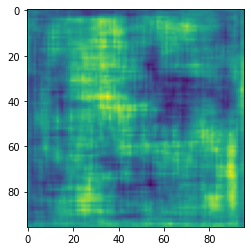

In [35]:
generator = create_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [36]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_16 (UpSampling (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 512)         2359808   
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 8, 512)         2048      
_________________________________________________________________
activation_20 (Activation)   (None, 8, 8, 512)         0         
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 16, 16, 512)      

In [37]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = create_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.5007689]], shape=(1, 1), dtype=float32)


In [38]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [39]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [40]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [41]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{:>02}:{:>05.2f}".format(m, s)

In [42]:
def train(dataset, epochs):
  start = time.time()

  for epoch in range(100):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}, {hms_string(epoch_elapsed)}')
    if epoch % 5 == 0:
      generator.save('/content/drive/MyDrive/MAG/mag.h5')
      print(f"Model Saved At Epoch {epoch}.")

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [43]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=1.7483866214752197,disc loss=1.6692348718643188, 00:17.29
Model Saved At Epoch 0.
Epoch 2, gen loss=2.5663368701934814,disc loss=1.5180639028549194, 00:13.07
Epoch 3, gen loss=2.7840685844421387,disc loss=0.9897773861885071, 00:13.16
Epoch 4, gen loss=2.1092147827148438,disc loss=1.7068819999694824, 00:13.24
Epoch 5, gen loss=2.049849510192871,disc loss=1.441208004951477, 00:13.28
Epoch 6, gen loss=2.720127582550049,disc loss=1.2870606184005737, 00:13.35
Model Saved At Epoch 5.
Epoch 7, gen loss=2.2319061756134033,disc loss=1.5376195907592773, 00:13.44
Epoch 8, gen loss=1.7940804958343506,disc loss=1.3377991914749146, 00:13.52
Epoch 9, gen loss=1.951067328453064,disc loss=1.498824954032898, 00:13.56
Epoch 10, gen loss=1.4952378273010254,disc loss=1.5007669925689697, 00:13.62
Epoch 11, gen loss=1.6485282182693481,disc loss=1.4783846139907837, 00:13.68
Model Saved At Epoch 10.
Epoch 12, gen loss=1.8731573820114136,disc loss=1.1147652864456177, 00:13.74
Epoch 13, gen los

In [ ]:
!pip install ipyplot
import ipyplot

In [45]:
import cv2


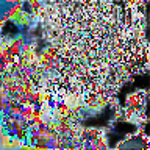
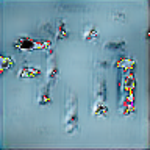
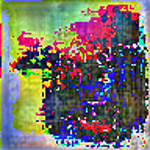
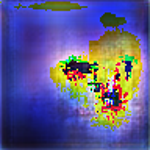
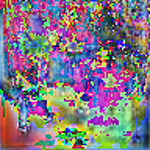
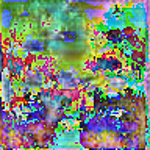
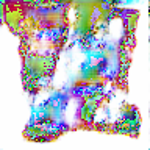
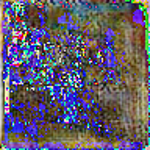
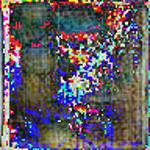
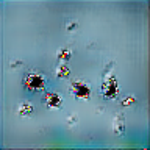
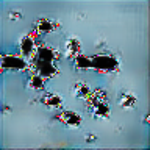
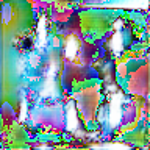
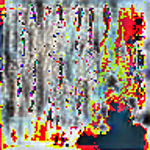
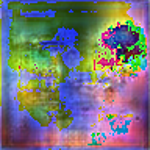
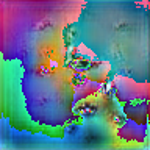
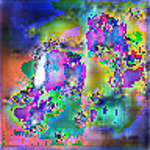
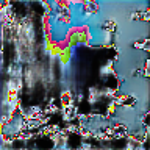
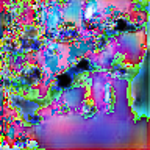
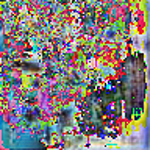
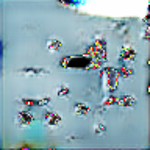
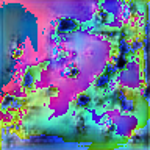
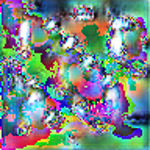
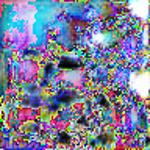
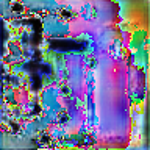
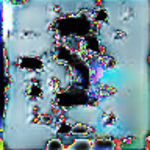
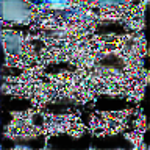
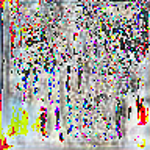
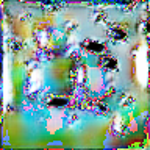
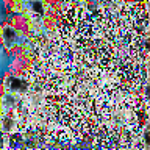
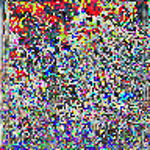


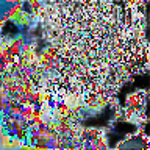
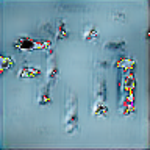
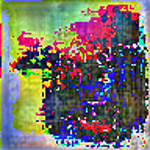
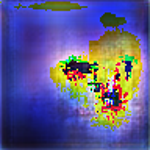
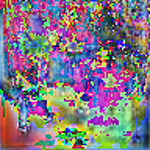
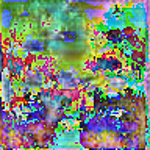
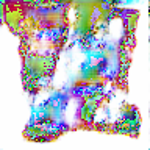
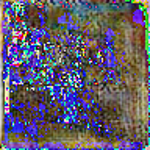
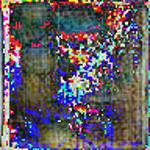
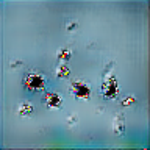
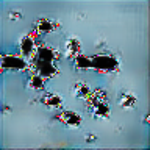
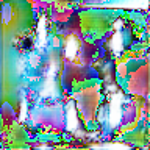
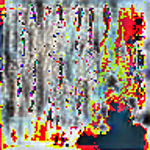
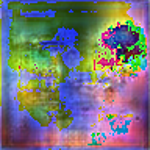
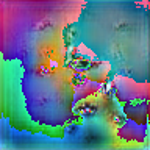
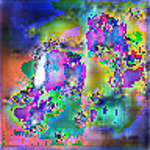
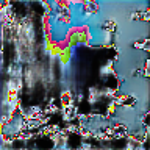
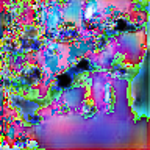
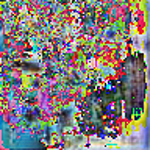
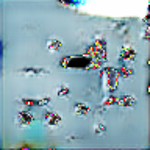
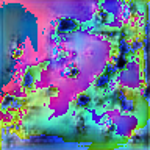
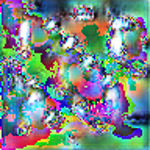
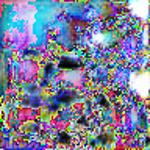
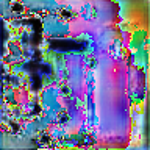
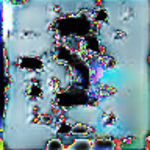
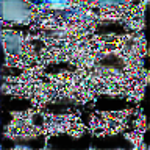
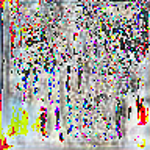
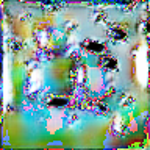
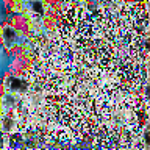
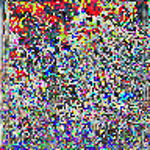

In [51]:
fixed_seed = np.random.normal(0, 1, (50, SEED_SIZE))
generated = generator.predict(fixed_seed)
generated = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in generated]
ipyplot.plot_images(generated, img_width=150)